## Desafío - Dimensionalidad y Agrupación (I)
### Cristian Vidal

### Contexto
Para esta actividad utilizaremos un subconjunto de 25 items de la International Personality Item
Pool, aplicados a 2800 individuos. El objetivo de esta información es desarrollar __perfiles de
personalidad__ en base a una serie de oraciones asociadas a las características Amabilidad,
Escrupolisidad, Extroversión, Neuroticismo, Apertura Los individuos deben responder qué tan
adecuada es la oración respecto a su personalidad en base a 6 categorías:

* 1: No me representa para nada.
* 2: No me representa.
* 3: Algunas cosas no me representan.
* 4: Algunas cosas me representan.
* 5: Me representa.
* 6: Me representa completamente.

Las 25 preguntas son:
* A1 Soy indiferente a los sentimientos de otros.
* A2 Me preocupo del bienestar de otros.
* A3 Sé cómo confortar a otros.
* A4 Me agradan los niños.
* A5 Hago sentir tranquila a la gente.
* C1 Soy exacto en mi trabajo.
* C2 Sigo con mis tareas hasta que todo esté perfecto.
* C3 Hago cosas siguiendo un plan.
* C4 Hago cosas con el mínimo esfuerzo.
* C5 Pierdo mi tiempo.
* E1 No hablo mucho con las personas.
* E2 Me es dificil acercarme a otros.
* E3 Sé cómo cautivar gente.
* E4 Hago amigos de forma fácil.
* E5 Puedo tomar el cargo de las cosas.
* N1 Me enojo con facilidad.
* N2 Me irrito con facilidad.
* N3 Tengo cambios de humor frecuentes.
* N4 Usualmente me siento melancólico.
* N5 Entro en pánico con facilidad.
* O1 Estoy lleno de ideas.
* O2 Evito leer material difícil.
* O3 Tiendo a llevar la conversación a niveles más altos.
* O4 Dedico tiempo a la reflexión de cosas.
* O5 No profundizaré sobre una materia específica.

Se registraron una serie de covariables sobre características demográficas de los encuestados:

* gender Hombre = 1, Mujer =2.
* education 1 = Educación Media Incompleta, 2 = Educación Media Completa, 3 = Educación Universitaria Incompleta, 4 = Educación Universitaria Completa, 5 = Estudios de Postgrado.
* age Edad en Años.

Implementaremos un modelo de extracción factorial para identificar los principales perfiles
psicológicos.

### Desafío 1: Lectura de archivos
* Importe las librerías necesarias para el análisis factorial siguiendo las convenciones.
* Importe la base de datos bfi.csv y asígnela a un objeto df .
* Solicite las primeras 5 observaciones con head .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats 
import seaborn as sns

import missingno as msngo

import factor_analyzer as fact

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings(action="ignore") 
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('bfi.csv')
df.head(5)

,Unnamed: 0,A1,A2,A3,A4,A5,C1,C2,C3,C4,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
0,61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,...,2.0,3.0,3.0,6,3.0,4.0,3.0,1,NaN,16
1,61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,...,5.0,5.0,4.0,2,4.0,3.0,3.0,2,NaN,18
2,61620,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,...,2.0,3.0,4.0,2,5.0,5.0,2.0,2,NaN,17
3,61621,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,...,4.0,1.0,3.0,3,4.0,3.0,5.0,2,NaN,17
4,61622,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,...,4.0,3.0,3.0,3,4.0,3.0,3.0,1,NaN,17


### Desafío 2: Preprocesamiento

* Elimine las columnas redundantes de la base, tal como 'Unnamed: 0' .

In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

* Analice el patrón de datos perdidos con missingno . Comente cuáles son las principales variables con mayores tasas de valores perdidos.

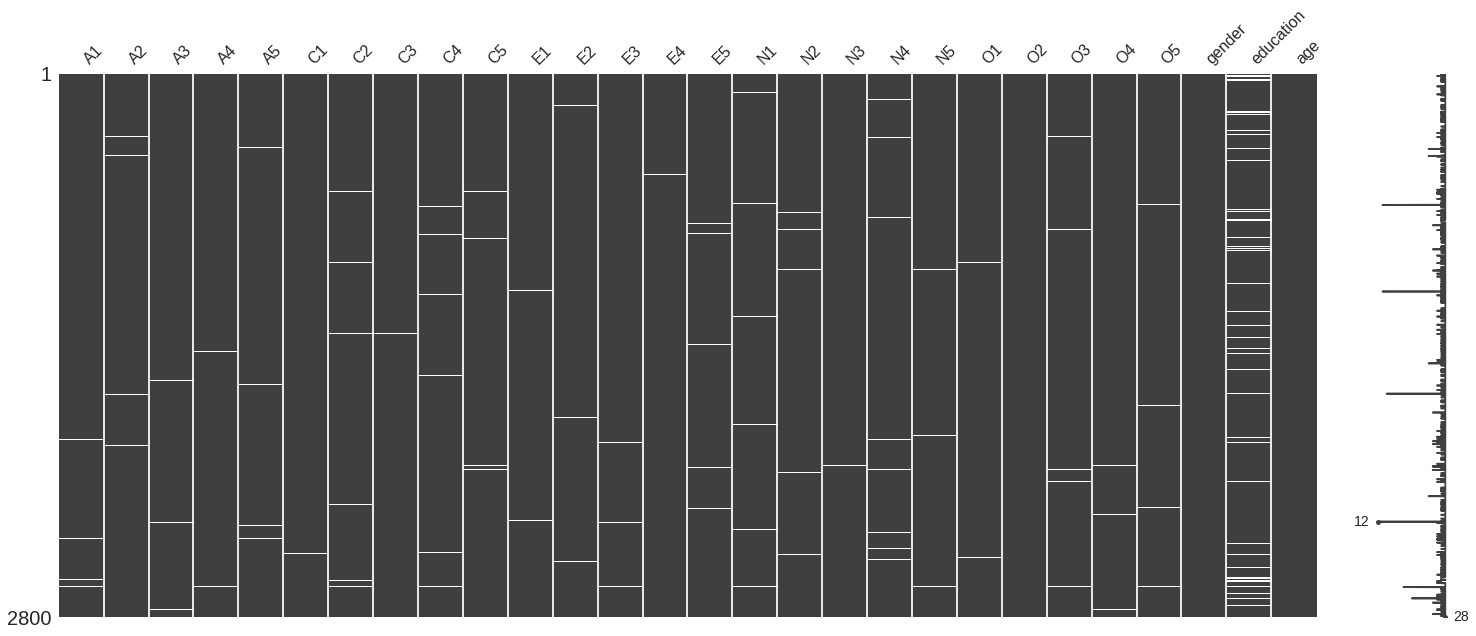

In [4]:
msngo.matrix(df)

In [5]:
def fetch_missing(df):
    variables_sin_datos_perdidos = ['age', 'gender', 'O2']
    for colname, serie in df.iteritems():
         if colname not in variables_sin_datos_perdidos:
            print(colname, serie.isna().value_counts('%')[1].round(3))
fetch_missing(df)

A1 0.006
A2 0.01
A3 0.009
A4 0.007
A5 0.006
C1 0.008
C2 0.009
C3 0.007
C4 0.009
C5 0.006
E1 0.008
E2 0.006
E3 0.009
E4 0.003
E5 0.008
N1 0.008
N2 0.008
N3 0.004
N4 0.013
N5 0.01
O1 0.008
O3 0.01
O4 0.005
O5 0.007
education 0.08


__Se observa que a lo largo de todas las preguntas las tasas de no respuesta son bajas, no superando el 1% del total de las observaciones. La variables con mayor cantidad de valores perdidos es education con 0.08.__

* Genere un nuevo objeto donde almacenará la base sin valores perdidos.

In [6]:
df_dropna = df.dropna()

In [7]:
df_dropna.head(5)

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
5,6.0,6.0,5.0,6.0,5.0,6.0,6.0,6.0,1.0,3.0,...,2.0,3.0,4.0,3,5.0,6.0,1.0,2,3.0,21
7,4.0,3.0,1.0,5.0,1.0,3.0,2.0,4.0,2.0,4.0,...,6.0,4.0,3.0,2,4.0,5.0,3.0,1,2.0,19
10,4.0,4.0,5.0,6.0,5.0,4.0,3.0,5.0,3.0,2.0,...,2.0,3.0,5.0,3,5.0,6.0,3.0,1,1.0,21
14,4.0,5.0,2.0,2.0,1.0,5.0,5.0,5.0,2.0,2.0,...,2.0,3.0,5.0,2,5.0,5.0,5.0,1,1.0,17
22,1.0,5.0,6.0,5.0,6.0,4.0,3.0,2.0,4.0,5.0,...,2.0,2.0,6.0,1,5.0,5.0,2.0,1,5.0,68


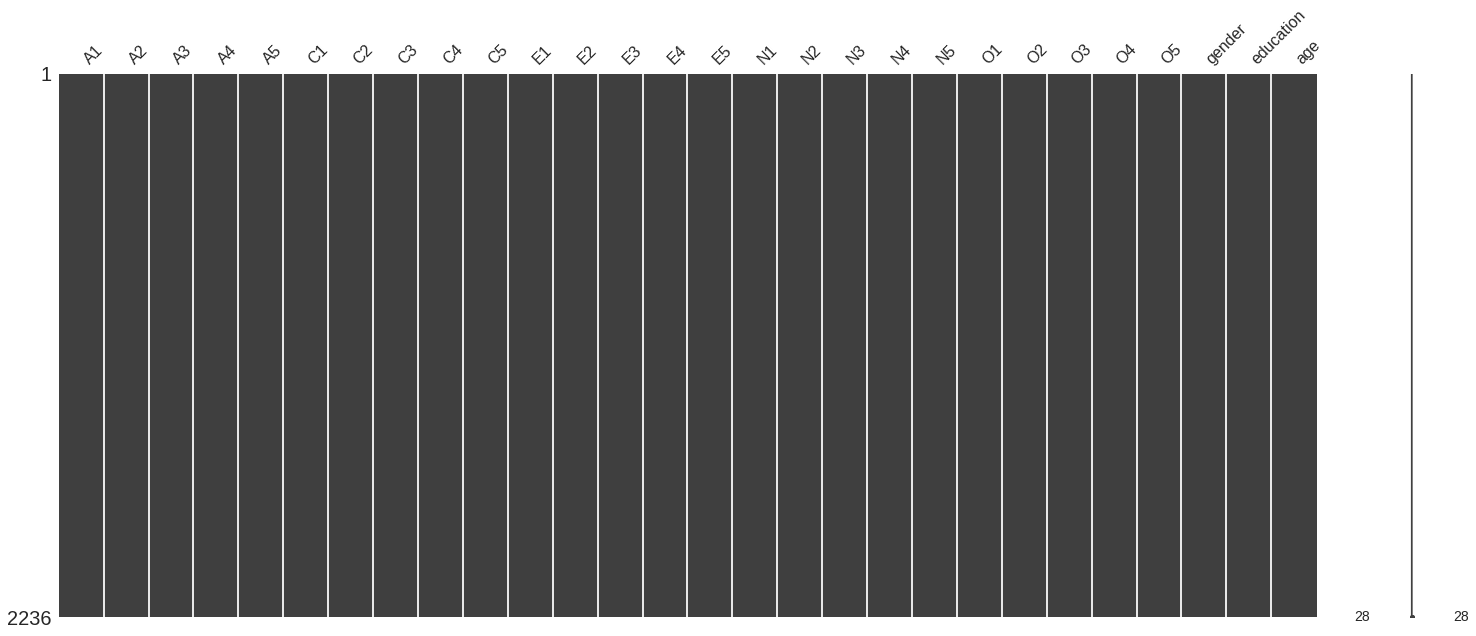

In [8]:
msngo.matrix(df_dropna)

### Desafío 3: Descripción

* Separe en un nuevo objeto DataFrame la batería de preguntas a extraer.

In [9]:
df_preguntas = df_dropna.drop(['gender', 'education', 'age'], axis=1)
df_preguntas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 5 to 2799
Data columns (total 25 columns):
A1    2236 non-null float64
A2    2236 non-null float64
A3    2236 non-null float64
A4    2236 non-null float64
A5    2236 non-null float64
C1    2236 non-null float64
C2    2236 non-null float64
C3    2236 non-null float64
C4    2236 non-null float64
C5    2236 non-null float64
E1    2236 non-null float64
E2    2236 non-null float64
E3    2236 non-null float64
E4    2236 non-null float64
E5    2236 non-null float64
N1    2236 non-null float64
N2    2236 non-null float64
N3    2236 non-null float64
N4    2236 non-null float64
N5    2236 non-null float64
O1    2236 non-null float64
O2    2236 non-null int64
O3    2236 non-null float64
O4    2236 non-null float64
O5    2236 non-null float64
dtypes: float64(24), int64(1)
memory usage: 454.2 KB


In [10]:
df_preguntas.sample(5)

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5
133,2.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,6.0,...,4.0,6.0,4.0,4.0,5.0,3.0,5,3.0,5.0,3.0
1768,6.0,4.0,1.0,5.0,4.0,5.0,4.0,5.0,5.0,6.0,...,1.0,1.0,1.0,1.0,1.0,6.0,5,1.0,5.0,5.0
648,2.0,4.0,4.0,5.0,2.0,5.0,5.0,1.0,1.0,6.0,...,2.0,2.0,4.0,6.0,4.0,2.0,2,6.0,5.0,1.0
2125,6.0,3.0,3.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,...,1.0,5.0,2.0,1.0,1.0,4.0,5,4.0,4.0,4.0
234,3.0,6.0,5.0,6.0,6.0,6.0,5.0,5.0,1.0,1.0,...,2.0,2.0,1.0,2.0,3.0,5.0,2,4.0,6.0,1.0


* Reporte las medias para cada uno de las preguntas de la batería. Esto lo puede lograr con un __dotplot__.

In [11]:
# Generamos dos arrays vacíos para guardar el nombre de la variable y la media
variable = []
mean = []

# para cada columna de la base, extraemos su nombre y sus valores
for colname, serie in df_preguntas.iteritems():
    # guardamos el nombre en variable
    variable.append(colname)
    # calculamos y procesamos la media
    mean.append(serie.mean())

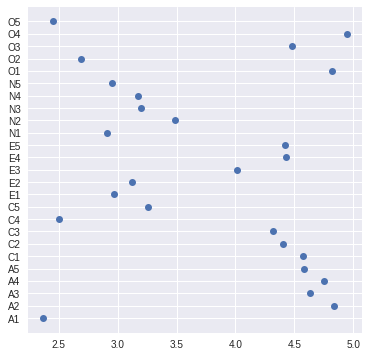

In [12]:
df_preguntas_mean_var = pd.DataFrame({'var':variable, 'mean': mean})
plt.figure(figsize=(6,6))
plt.plot(df_preguntas_mean_var['mean'], df_preguntas_mean_var['var'],'o')

__Ordenamos nuestra información__

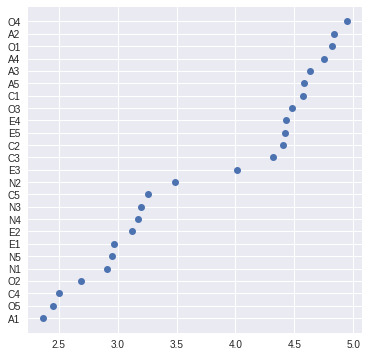

In [13]:
df_preguntas_mean_var = pd.DataFrame({'var':variable, 'mean': mean}).sort_values(by=['mean'])
plt.figure(figsize=(6,6))
plt.plot(df_preguntas_mean_var['mean'], df_preguntas_mean_var['var'],'o')

* Genere una matriz de correlaciones con este nuevo objeto. Visualícelo con __heatmap__

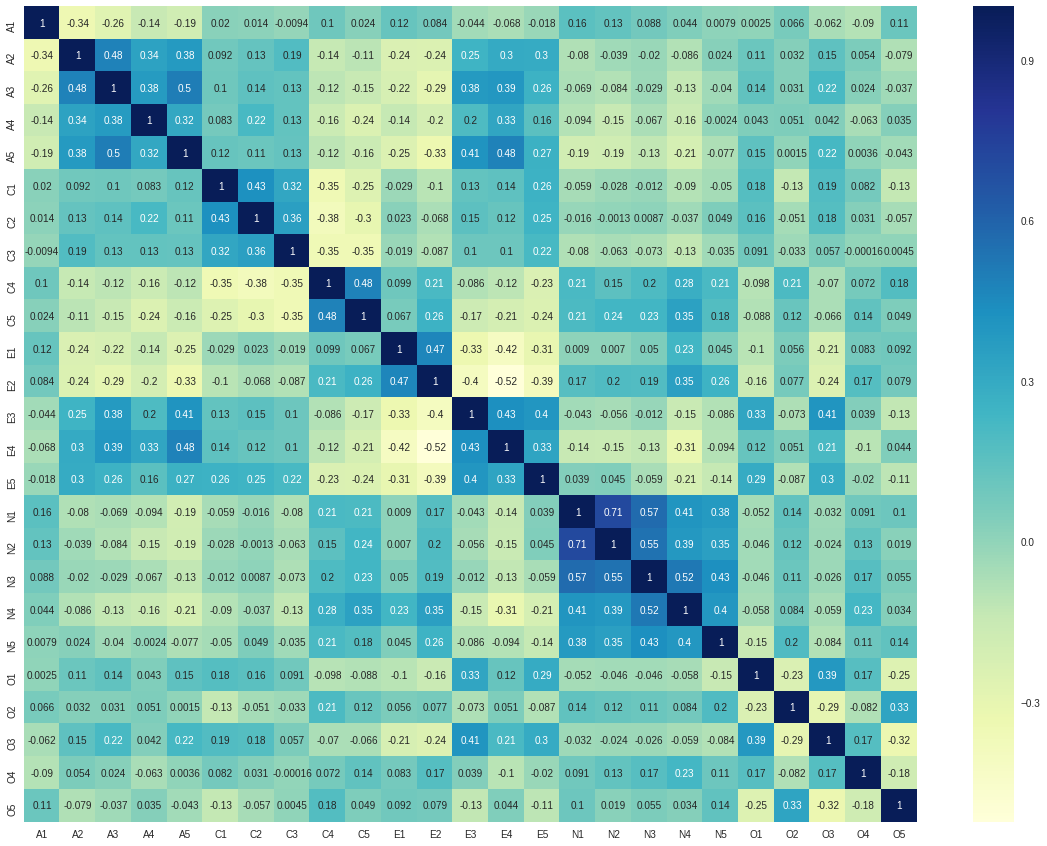

In [14]:
plt.figure(figsize=(20,15))
sns.heatmap(df_preguntas.corr(), annot=True, cmap="YlGnBu")

* Comente sobre los principales patrones de correlación entre las preguntas de la batería.

__Los valores mas altos en la scala significa que tanto representa al individuo encuestado. En un extremo observamos las variables: "Dedico tiempo a la reflexión de cosas", "Me preocupo del bienestar de otros", "Estoy lleno de ideas", "Me agradan los niños", "Sé cómo confortar a otros".__

__En el otro extremos encontramos variables como "Me enojo con facilidad", "Evito leer material difícil", "Hago cosas con el mínimo esfuerzo", "No profundizaré sobre una materia específica".__

__Podemos observar que existe:__
* Una correlacion alta entre __"Me irrito con facilidad"__ y __"Me enojo con facilidad"__ de __0.71__.
* Una correlacion moderada entre __"Tengo cambios de humor frecuentes"__ y __"Me enojo con facilidad"__ de __0.57__.
* Una correlacion moderada entre __"Tengo cambios de humor frecuentes"__ y __"Me irrito con facilidad"__ de __0.55__.
* Una correlacion moderada entre __"Entro en pánico con facilidad"__ y __"Tengo cambios de humor frecuentes"__ de __0.4__.

### Desafío 4: Extracción de factores
* Antes de iniciar la extracción de factores, inspeccione la ideonidad de la batería de preguntas para realizar un análisis factorial mediante la prueba de esferacidad de Barlett y Kaiser-Meyer-Olkin. Comente los resultados.


In [15]:
fact.calculate_bartlett_sphericity(df_preguntas)

(16509.6735504972, 0.0)

__En este caso, la prueba de esferacidad de errores sugiere que la matriz de correlaciones no es igual a la matriz de identidad, por lo que se puede seguir con el análisis.__

In [16]:
kmo_all,kmo_model= fact.calculate_kmo(df_preguntas)
kmo_model

0.8468295031833752

__El KMO general para nuestros datos es 0.84, que es excelente. Este valor indica que podemos continuar con nuestro análisis factorial.__

* Instancie un objeto con FactorAnalyzer() donde se estimen 10 dimensiones latentes y no se aplique rotación.


In [17]:
factorize = fact.FactorAnalyzer(n_factors=10, rotation=None)
factorize.fit(df_preguntas)
factor_screeplot = factorize.get_eigenvalues()[0]
factor_screeplot

array([5.06851622, 2.7624793 , 2.152623  , 1.89233295, 1.51753291,
       1.07882932, 0.83090573, 0.80450025, 0.7140883 , 0.7015381 ,
       0.6808421 , 0.64897347, 0.63125633, 0.58803197, 0.5659652 ,
       0.54483958, 0.51993349, 0.49386855, 0.48273618, 0.44250032,
       0.42887063, 0.40709741, 0.38887531, 0.38476259, 0.2681008 ])

* Genere un scree plot entre los eigenvalues del modelo y la cantidad de dimensiones estimables.

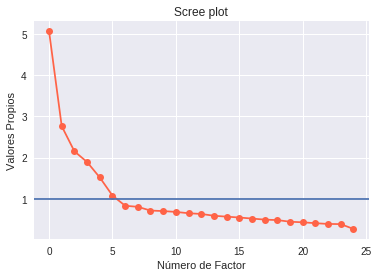

In [18]:
plt.plot(np.arange(len(factor_screeplot)), factor_screeplot, 'o-', color='tomato')
plt.xlabel('Número de Factor')
plt.ylabel('Valores Propios')
plt.axhline(1)
plt.title("Scree plot");

* Refactorice el objeto con FactorAnalyzer() para incluir la cantidad de dimensiones válidas que informó el scree plot.

In [19]:
factorize_refactor = fact.FactorAnalyzer(n_factors=6, rotation="varimax")
factorize_refactor.fit(df_preguntas)
factor_screeplot_refactor = factorize_refactor.get_eigenvalues()[0]
factor_screeplot_refactor

array([5.06851622, 2.7624793 , 2.152623  , 1.89233295, 1.51753291,
       1.07882932, 0.83090573, 0.80450025, 0.7140883 , 0.7015381 ,
       0.6808421 , 0.64897347, 0.63125633, 0.58803197, 0.5659652 ,
       0.54483958, 0.51993349, 0.49386855, 0.48273618, 0.44250032,
       0.42887063, 0.40709741, 0.38887531, 0.38476259, 0.2681008 ])

In [20]:
factor_loadings = pd.DataFrame(factorize_refactor.loadings_)
factor_loadings.set_index(df_preguntas.columns, inplace=True)
factor_loadings.columns = ['Factor1', 'Factor2', 
                           'Factor3', 'Factor4', 
                           'Factor5', 'Factor6']
factor_loadings

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
A1,0.091842,0.034574,0.058442,-0.534061,-0.117714,0.151041
A2,0.041722,0.255285,0.133053,0.643604,0.044379,-0.014106
A3,-0.004844,0.365737,0.125638,0.577347,0.025995,0.171016
A4,-0.073323,0.226775,0.229118,0.392654,-0.144223,0.097317
A5,-0.144079,0.424070,0.105918,0.446259,0.026051,0.240763
C1,0.004703,0.074012,0.546749,-0.001942,0.192075,0.077785
C2,0.069577,0.035041,0.663273,0.057794,0.082833,0.151471
C3,-0.042383,0.044282,0.553655,0.093830,-0.011788,0.010914
C4,0.222028,-0.067121,-0.633327,-0.098124,-0.122705,0.320747
C5,0.278775,-0.182135,-0.545082,-0.044880,0.034981,0.125161


In [21]:
factorize_refactor.get_factor_variance()

(array([2.72320933, 2.6764241 , 2.04679654, 1.60625748, 1.53677901,
        0.62241748]),
 array([0.10892837, 0.10705696, 0.08187186, 0.0642503 , 0.06147116,
        0.0248967 ]),
 array([0.10892837, 0.21598534, 0.2978572 , 0.3621075 , 0.42357866,
        0.44847536]))

* Extraiga las cargas del modelo e identifique qué items están asociados a cada factor. Comente sobre qué significa cada factor construído.

In [22]:
factor_loadings.applymap(lambda x: np.where(x < .4, ' ', round(x, 2)))

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
A1,,,,,,
A2,,,,0.64,,
A3,,,,0.58,,
A4,,,,,,
A5,,0.42,,0.45,,
C1,,,0.55,,,
C2,,,0.66,,,
C3,,,0.55,,,
C4,,,,,,
C5,,,,,,


__Factor 6 no tiene ninguna variable. Es bueno si tomamos solo cinco factores. Realicemos un análisis factorial para 5 factores.__

In [23]:
factorize_refactor_2 = fact.FactorAnalyzer(n_factors=5, rotation="varimax")
factorize_refactor_2.fit(df_preguntas)
factor_screeplot_refactor_2 = factorize_refactor_2.get_eigenvalues()[0]

In [24]:
factor_loadings_2 = pd.DataFrame(factorize_refactor_2.loadings_)
factor_loadings_2.set_index(df_preguntas.columns, inplace=True)
factor_loadings_2.columns = ['Factor1', 'Factor2' , 'Factor3', 'Factor4', 'Factor5']
factor_loadings_2

,Factor1,Factor2,Factor3,Factor4,Factor5
A1,0.105915,0.037575,0.034817,-0.419281,-0.090180
A2,0.036656,0.221793,0.136786,0.607552,0.044579
A3,0.013753,0.322666,0.111741,0.638390,0.045098
A4,-0.059559,0.198711,0.223102,0.433899,-0.133771
A5,-0.117891,0.384458,0.086868,0.532139,0.054284
C1,0.017813,0.063871,0.540611,0.032170,0.205165
C2,0.089182,0.022303,0.638851,0.110623,0.102335
C3,-0.034199,0.032465,0.559417,0.108153,-0.006682
C4,0.243565,-0.074349,-0.627098,-0.026737,-0.098906
C5,0.283761,-0.180192,-0.561464,-0.037165,0.040883


In [25]:
factor_loadings_2.applymap(lambda x: np.where(x < .4, ' ', round(x, 2)))

,Factor1,Factor2,Factor3,Factor4,Factor5
A1,,,,,
A2,,,,0.61,
A3,,,,0.64,
A4,,,,0.43,
A5,,,,0.53,
C1,,,0.54,,
C2,,,0.64,,
C3,,,0.56,,
C4,,,,,
C5,,,,,


* __Las cargas señalan que el Factor 1 se compone de N1, N2, N3, N4 y N5 (Neuroticismo)__
* __Las cargas señalan que el Factor 2 se compone de E3, E4, E5 (Extroversión)__
* __Las cargas señalan que el Factor 3 se compone de C1, C2, C3 (Escrupolisidad)__
* __Las cargas señalan que el Factor 4 se compone de A2, A3, A4, A5 (Amabilidad)__
* __Las cargas señalan que el Factor 5 se compone de O1, O3 (Apertura)__

### Desafío 5: Modelación de factores

* Extraiga los puntajes del modelo factorial a su base de datos.

In [26]:
extract_factor_scores = factorize_refactor_2.transform(df_preguntas)
extract_factor_scores

array([[ 0.24179489,  1.09038802,  1.28956316, -0.143249  ,  0.26342121],
       [ 0.38698565, -1.30359959, -0.78869171, -1.91913201, -0.40414282],
       [-0.1558489 ,  0.27283528, -0.21929233, -0.10225699, -0.3362664 ],
       ...,
       [-0.19917884,  0.73659721,  0.77760216, -1.11735093,  0.92245137],
       [ 0.94956412,  0.72029203,  0.03697372, -2.15012933,  0.65486459],
       [-1.66480942, -1.37011941, -0.15098196, -1.89248216, -0.16950781]])

* Grafique la densidad de cada uno con kdplot .

__Densidad con distplot__

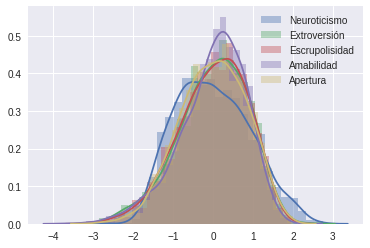

In [27]:
sns.distplot(extract_factor_scores[:, 0], label="Neuroticismo")
sns.distplot(extract_factor_scores[:, 1], label="Extroversión")
sns.distplot(extract_factor_scores[:, 2], label="Escrupolisidad")
sns.distplot(extract_factor_scores[:, 3], label="Amabilidad")
sns.distplot(extract_factor_scores[:, 4], label="Apertura")
plt.legend()

__Densidad con kdeplot__

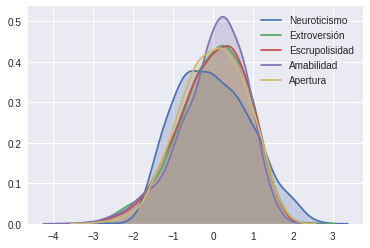

In [28]:
sns.kdeplot(extract_factor_scores[:, 0],shade=True, label="Neuroticismo")
sns.kdeplot(extract_factor_scores[:, 1], shade=True, label="Extroversión")
sns.kdeplot(extract_factor_scores[:, 2], shade=True, label="Escrupolisidad")
sns.kdeplot(extract_factor_scores[:, 3], shade=True, label="Amabilidad")
sns.kdeplot(extract_factor_scores[:, 4], shade=True, label="Apertura")

* Modele y comente brevemente sobre cuáles son los principales determinantes de cada factor en base al siguiente modelo estimable:

In [29]:
extract_factor_scores_df = pd.DataFrame(extract_factor_scores)
extract_factor_scores_df.columns = ['Neuroticismo', 'Extroversión' , 'Escrupolisidad', 'Amabilidad', 'Apertura']

In [30]:
df_dropna.reset_index(drop=True, inplace=True)

In [31]:
df_final_factor = pd.concat([df_dropna, extract_factor_scores_df], axis=1)
df_final_factor.head(5)

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,O4,O5,gender,education,age,Neuroticismo,Extroversión,Escrupolisidad,Amabilidad,Apertura
0,6.0,6.0,5.0,6.0,5.0,6.0,6.0,6.0,1.0,3.0,...,6.0,1.0,2,3.0,21,0.241795,1.090388,1.289563,-0.143249,0.263421
1,4.0,3.0,1.0,5.0,1.0,3.0,2.0,4.0,2.0,4.0,...,5.0,3.0,1,2.0,19,0.386986,-1.303600,-0.788692,-1.919132,-0.404143
2,4.0,4.0,5.0,6.0,5.0,4.0,3.0,5.0,3.0,2.0,...,6.0,3.0,1,1.0,21,-0.155849,0.272835,-0.219292,-0.102257,-0.336266
3,4.0,5.0,2.0,2.0,1.0,5.0,5.0,5.0,2.0,2.0,...,5.0,5.0,1,1.0,17,-0.434364,0.023121,0.709011,-1.698283,-0.261523
4,1.0,5.0,6.0,5.0,6.0,4.0,3.0,2.0,4.0,5.0,...,5.0,2.0,1,5.0,68,-1.014068,0.214634,-1.672834,0.750211,0.418495


In [32]:
modelo_factor_1 = smf.ols('Neuroticismo ~ gender + education + age', data = df_final_factor).fit()
modelo_factor_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Neuroticismo   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     17.57
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           2.82e-11
Time:                        01:02:07   Log-Likelihood:                -2969.1
No. Observations:                2236   AIC:                             5946.
Df Residuals:                    2232   BIC:                             5969.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0794      0.098     -0.812      0.417      -0.271       0.112
gender         0.2220      0.041      5.392      0.000       0.141       0.303
education     -0.0079      0.018     -0.441      0.659      -0.043       0.027
age           -0.0090      0.002     -4.818      0.000      -0.013      -0.005
==============================================================================
Omnibus:                       67.977   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.633
Skew:                           0.280   Prob(JB):                     6.14e-12
Kurtosis:                       2.510   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
modelo_factor_2 = smf.ols('Extroversión ~ gender + education + age', data = df_final_factor).fit()
modelo_factor_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Extroversión   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7.591
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           4.75e-05
Time:                        01:02:07   Log-Likelihood:                -2867.2
No. Observations:                2236   AIC:                             5742.
Df Residuals:                    2232   BIC:                             5765.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2714      0.093     -2.905      0.004      -0.455      -0.088
gender         0.1764      0.039      4.483      0.000       0.099       0.254
education     -0.0234      0.017     -1.362      0.173      -0.057       0.010
age            0.0017      0.002      0.968      0.333      -0.002       0.005
==============================================================================
Omnibus:                       64.892   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.195
Skew:                          -0.433   Prob(JB):                     5.72e-16
Kurtosis:                       2.944   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
modelo_factor_3 = smf.ols('Escrupolisidad ~ gender + education + age', data = df_final_factor).fit()
modelo_factor_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Escrupolisidad   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     9.331
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.95e-06
Time:                        01:02:07   Log-Likelihood:                -2823.1
No. Observations:                2236   AIC:                             5654.
Df Residuals:                    2232   BIC:                             5677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4108      0.092     -4.484      0.000      -0.590      -0.231
gender         0.1467      0.039      3.802      0.000       0.071       0.222
education     -0.0038      0.017     -0.229      0.819      -0.037       0.029
age            0.0060      0.002      3.435      0.001       0.003       0.009
==============================================================================
Omnibus:                       71.253   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.720
Skew:                          -0.456   Prob(JB):                     1.33e-17
Kurtosis:                       2.960   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
modelo_factor_4 = smf.ols('Amabilidad ~ gender + education + age', data = df_final_factor).fit()
modelo_factor_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Amabilidad   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     38.53
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           2.86e-24
Time:                        01:02:07   Log-Likelihood:                -2723.1
No. Observations:                2236   AIC:                             5454.
Df Residuals:                    2232   BIC:                             5477.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8109      0.088     -9.256      0.000      -0.983      -0.639
gender         0.3661      0.037      9.923      0.000       0.294       0.438
education      0.0104      0.016      0.644      0.520      -0.021       0.042
age            0.0056      0.002      3.352      0.001       0.002       0.009
==============================================================================
Omnibus:                      157.288   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.108
Skew:                          -0.661   Prob(JB):                     7.08e-43
Kurtosis:                       3.580   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
modelo_factor_5 = smf.ols('Apertura ~ gender + education + age', data = df_final_factor).fit()
modelo_factor_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Apertura   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     25.10
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           5.70e-16
Time:                        01:02:07   Log-Likelihood:                -2721.1
No. Observations:                2236   AIC:                             5450.
Df Residuals:                    2232   BIC:                             5473.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0087      0.088     -0.099      0.921      -0.180       0.163
gender        -0.2176      0.037     -5.904      0.000      -0.290      -0.145
education      0.0900      0.016      5.602      0.000       0.059       0.122
age            0.0029      0.002      1.720      0.086      -0.000       0.006
==============================================================================
Omnibus:                       31.431   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.261
Skew:                          -0.253   Prob(JB):                     2.69e-07
Kurtosis:                       2.738   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""